
---
<big><big><big><big><big><big>Metody uczenia maszynowego</big></big></big></big></big></big>

---





---
<big><big><big><big><big>Problem klasyfikacji</big></big></big></big></big>

---



---

<id=tocheading><big><big><big><big>Spis treści</big></big></big></big>
<div id="toc"></div>

---

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use("fivethirtyeight")

from bokeh.io import gridplot, output_file, show
from bokeh.plotting import figure, output_notebook
from bkcharts import Scatter

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import Perceptron, LinearRegression, LogisticRegression
from sklearn.preprocessing import scale
from scipy.stats import gaussian_kde

In [4]:
from sklearn.datasets import make_circles, make_classification, make_hastie_10_2, make_moons
from sklearn.datasets import make_multilabel_classification, make_blobs
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from matplotlib.colors import ListedColormap


In [5]:
output_notebook()
sns.set(font_scale=2.0)

Loading BokehJS ...

Image inclusion
<img src="../mum_figures/" width="100%">

# Zadanie klasyfikacji
1. __K__ klas $c_k; k=1,\dots,K$
  * __rozłączne__ zwykle
  * __klasyfikacja wieloklasowa__ gdy $K>2$ (_ang._ multi-class)
  * __wielo etykietowa__ gdy klasy _nie są_ rozłączne (_ang._ multi label)
2. __brak wiedzy__ o klasach
  * __one hot__ wygodna reprezentacja $$y=(0,\dots,0,1,0,\dots,0)$$
  gdzie $y_k=1$
3. __notacja__ (starałem się nie pomylić, ale jeśli to przepraszam - proszę o uwagę)
  * $c_k$ k-ta klasa, $c_k\in C_k$
  * $y_k$ k-ty przykład
  * $\widehat{y}_k$ wartość na pozycji k-tej wektora $\widehat{y}$

# Podejścia
1. __dyskryminatywne__ (reprezentacja _one-hot_ klas) $$\widehat{y}(x)=(0,\dots,0,1,0,\dots,0)$$ jeśli odpowiedzią jest, że $x$ należy do klasy $k$
2. __probabilistyczne__ zwracają __szanse__ przynależenia do klas
  1. modeluje rozkłady parametryczne $$P(C_k\mid X)$$ i optymalizuje je na podstawie zbioru uczącego
  2. __bayesowski__ $$P(y=c_k\mid x)=\frac{p(x\mid y=c_k)\,p(c_k)}{p(x)}$$ z _likelihood_ $p(x\mid y=c_k)$ i _priorem_ $p(c_k)$

# Uogólnione modele liniowe (generalized linear models)
1. __liniowy__ $$y(x)=\theta^Tx+\theta_0$$
2. __prawdopodobieństwo__ ma należeć do $[0, 1]$
3. __płaszczyzna decyzyjna__ $y(x)=0$
4. __uogólniony liniowy__ $$y(x)=\sigma(\theta^Tx+\theta_0)$$
  * __nieliniowa__ $\sigma()$
    * __funkcja aktywacji__ w ML
  * model __nie jest już__ liniowy ze względu na parametry

# Model dyskryminatywny
---
## Problem $K=2$
$$y(x)=\theta^T+\theta_0$$
1. prosta __reguła klasyfikacji__ $$k=0\hskip1em\text{jeśli}\hskip1em{}y(x)\geq0\hskip1em\text{w przeciwnym wypadku}\hskip1em{}k=1$$
  * niech $X\subseteq\mathbb{R}^D$
  * $y(x)$ odpowiada $D-1$-wymiarowej __hiperpłaszczyźnie__
2. __liniowa separowalność__ gdy istnieje $y(x)=0$ rozdzielająca
3. zadanie klasyfikacji problemu separowalnego
  * __dowolna__ hiperpłaszczyzna rozdzielająca
  * hiperpłaszczyzna __maksymalizująca__ odległości od przykładów
4. __rozszerzone wejście__ (w _domyśle_ zawsze takie) $$\widetilde{x}=[1, x]$$

In [6]:
def simple_two_class():
    x, y = make_blobs(n_samples=40, n_features=2, centers=2)
    x = scale(x)
    eps = 0.1
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    colors = sns.color_palette("Accent", 2)
    plt.scatter(x[:, 0], x[:, 1], s=100, c=[colors[k] for k in y], edgecolor='k')
    x_lin = np.linspace(min(x[:, 0]), max(x[:, 0]), 5)
    it_list = (1, 4, 16, 64, 256, 1024, 4096, 16384)
    colors = sns.color_palette("Paired", len(it_list))
    lt = ['-', '--']
    for k, it in enumerate(it_list):
        pr = Perceptron(max_iter=it, random_state=it)
        pr.fit(x, y)
        cf = pr.coef_[0]
        y_hyperplane = (-cf[0] / cf[1] * x_lin + pr.intercept_)
        ax.plot(x_lin, y_hyperplane, '-.', label="{} iter".format(it), c=colors[k])
    ax.set_xlim((min(x[:, 0]) - eps, max(x[:, 0]) + eps))
    ax.set_ylim((min(x[:, 1]) - eps, max(x[:, 1]) + eps))
    ax.legend(loc="best")

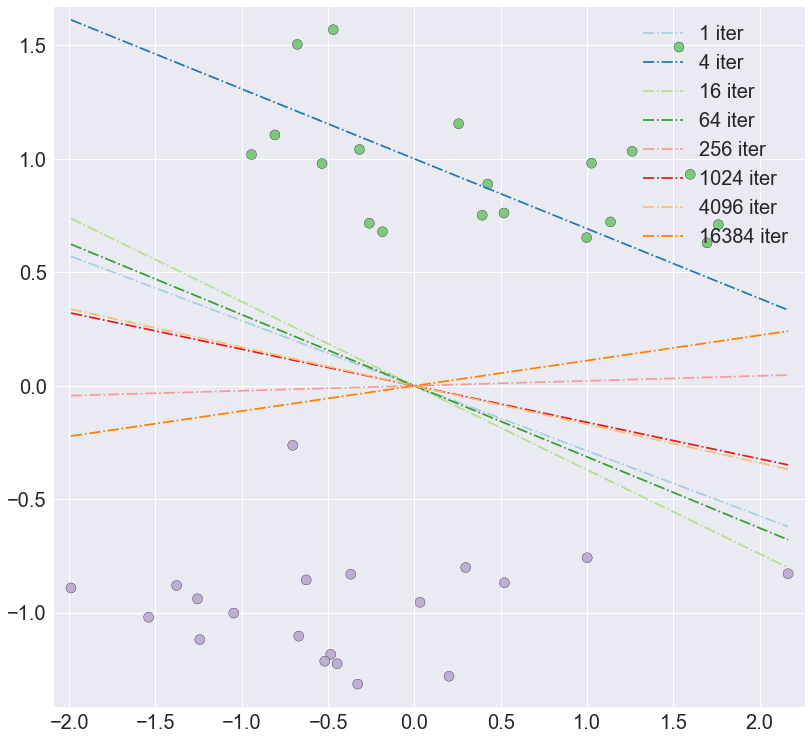

In [7]:
simple_two_class()

## Funkcja dyskryminatywna
1. funkcja __dyskryminatywna__ $$\widehat{y}=g(x)=f(y\mid x)$$  daje najlepszą prawdopodobną klasyfikację $x$
$$\begin{align}
g(x)=f(y\mid x)&=\int yp(y\mid x)dy\\
&=1\cdot p(y=1\mid x)+0\cdot p(y=0\mid x)\\&=p(y=1\mid x)
\end{align}$$
  * $g(x)$ rozpoznaje klasę $1$
2. z __reguły Bayesa__
$$\begin{align}
g(x)=p(y=c_1\mid x)&=\frac{p(x_i\mid c_k)\,p(c_k)}{\sum_l p(x_i\mid c_l)\,p(c_l)}\\
&=\frac{p(x\mid y=c_1)\,p(y=c_1)}{p(x\mid y=c_1)\,p(y=c_1)+p(x\mid y=c_0)\,p(y=c_0)}\\
&=\frac{\pi_1 p(x\mid y=c_1)}{\pi_1 p(x\mid y=c_1)+\pi_0 p(x\mid y=c_0)}\\
&=\frac{\pi_1 p_1(x)}{\pi_1 p_1(x)+\pi_0 p_0(x)}
\end{align}$$
gdzie $\pi_i=p(y=c_i)$ __prior__ klasy
  * _prior_ klasy może być obliczony ze zbioru uczącego

## Problem $K>2$
1. przez __złożenie__ klasyfikatorów 2-klasowych
2. __one versus the rest__
  * $K-1$ klsyfikatorów
  * każdy 2-klasowy dla problemu _klasa i vs inne klasy_
  * __niejednoznaczność__ obszary bez klasyfikacji
3. __one versus one__
  * $K(K-1)$ klasyfikatorów binarnych
  * __niejednoznaczność__ obszary konfliktowe
4. __K klasyfikatorów__ $$\widehat{y}_k(x)=\theta^T_kx+\theta_{k,0}$$
  * $\widehat{y}_k(x)$ rozpoznaje klasę $k$
  * przypisanie
  $$k=\underset{j}{\arg\max}\;\pi_j\,p(x\mid y=c_j)\hskip3emj=1,\dots,K\;$$
  * hiperpłaszczyzny __rozdzielające__ spełniające
  
  $$\begin{align}
  \widehat{y}_j(x)&=\widehat{y}_k(x)\hskip2em\forall\;j\neq{}k\\\\
  \widehat{y}_j(x)-\widehat{y}_k(x)&=0\\\\
  \theta^T_jx+\theta_{j,0} - \theta^T_kx+\theta_{k,0}&=0\\\\
  (\theta_j-\theta_k)^Tx+(\theta_{j,0}-\theta_{k,0})&=0
  \end{align}$$

## Metoda najmniejszych kwadratów
1. __one-hot__ $y$
  * jeśli z klasy $k$, to $y_k=1$
    * jedynka na $k$-tej pozycji wektora y
  * w przeciwnym wypadku $0$
2. układ równań $$\widehat{y}_k(x)=\theta_k^Tx+w_{k0}$$
opisujących __przynależność__ do klasy $k$
3. __przypisanie__ do klasy, dla której $\widehat{y}_k(x)$ _największa_
4. __minimalizacja__ sumy kwadratów __po _przykładach_ i po _klasach___
$$L(\theta)=\frac{1}{2}\sum_{n=1}^N\sum_{k=1}^K\left(\widehat{y}_k(x)-y_{n,k}\right)^2$$
5. __problemy__
  * __dobrze rozdzielone__ klasy daje wynik OK
  * wartości $\widehat{y}_k(x)$ nie ograniczone do $[0,1]$
    * nie bardzo porównywalne
    * niemożliwe do interpretacji jako prawdopodobieństwo
  * przykłady odległe od płaszczyzny decyzyjnej
    * ___łatwe___ do klasyfikacji
    * przesuwają hipepłaszczyznę decyzyjną!
6. model rozwiązuje inne problem
  * minimalizuje odległaści od hiperpłaszczyzny
  * powinien _maksymalizować_!

In [8]:
def simple_least_squares():
    x, y = make_blobs(n_samples=40, n_features=2, centers=2)
    x = scale(x)
    eps = 0.1
    x_app = [xx for (xx, yy) in zip(x, y) if yy > 0]
    x_app = np.array(x_app)
    y_app = np.ones(x_app.shape[0])
    x_app = x_app * 2 + 2
    x_alt = np.concatenate((x, x_app), axis=0)
    y_alt = np.concatenate((y, y_app), axis=0)

    fig, ax = plt.subplots(2, 1, figsize=(12, 15))
    colors_acc = sns.color_palette("Accent", 2)
    ax[0].scatter(x[:, 0], x[:, 1], s=100, c=[colors_acc[k] for k in y], edgecolor='k')
    x_lin = np.linspace(min(x_alt[:, 0]), max(x_alt[:, 0]), 5)
    ls = LinearRegression(fit_intercept=False)
    ls.fit(x, y)
    it_list = (1, 4, 16, 64, 256, 1024, 4096, 16384)
    colors = sns.color_palette("Paired", len(it_list))
    cf = ls.coef_
    y_hyperplane = -cf[0] / cf[1] * x_lin + ls.intercept_
    ax[0].plot(x_lin, y_hyperplane, '-.', label="2 clusters", c=colors[0])
    ax[0].legend(loc="best")
    
    x = x_alt
    y = y_alt
    ax[1].scatter(x[:, 0], x[:, 1], s=100, c=[colors_acc[int(k)] for k in y], edgecolor='k')
    ls = LinearRegression()
    ls.fit(x, y)
    cf = ls.coef_
    y_hyperplane_alt = -cf[0] / cf[1] * x_lin + ls.intercept_
    ax[1].plot(x_lin, y_hyperplane, '-.', label="2 clusters", c=colors[0])
    ax[1].plot(x_lin, y_hyperplane_alt, '-.', label="extra cluster added", c=colors[1])
    ax[0].set_xlim((min(x[:, 0]) - eps, max(x[:, 0]) + eps))
    ax[0].set_ylim((min(x[:, 1]) - eps, max(x[:, 1]) + eps))
    ax[1].set_xlim((min(x[:, 0]) - eps, max(x[:, 0]) + eps))
    ax[1].set_ylim((min(x[:, 1]) - eps, max(x[:, 1]) + eps))
    ax[1].legend(loc="best")

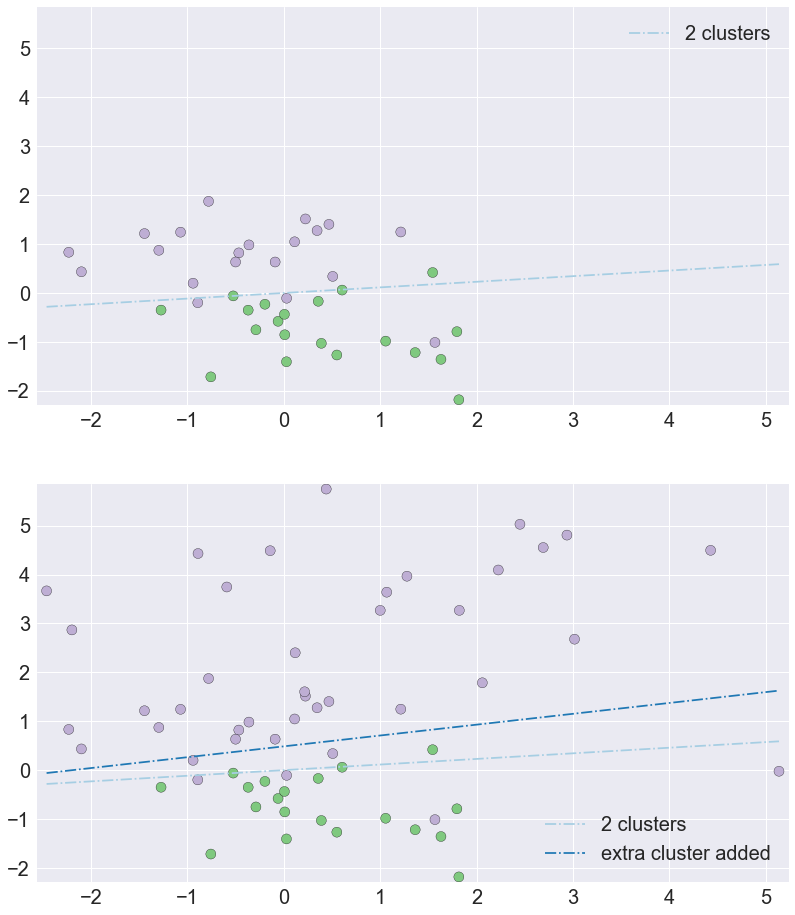

In [9]:
simple_least_squares()

# Klasyfikacja probabilistyczna

1. __klasyfikator Bayesowski__ dla 2 klas
$$\begin{align}
\widehat{y}&=\begin{cases}c_1\hskip{2em}g(x)>1/2\\c_0\hskip{2em}wpp\end{cases}\\
&=\begin{cases}c_1\hskip{2em}p(y=c_1\mid x)>p(y=c_0\mid x)\\c_0\hskip{2em}wpp\end{cases}\\
&=\begin{cases}c_1\hskip{2em}\pi_1p_1(x)>\pi_0p_0(x)\\c_0\hskip{2em}wpp\end{cases}
\end{align}$$
1. dla większej liczby klas __Bayesowska reguła klasyfikacji__

$$
k=\underset{j}{\arg\max}\;\pi_j\,p(x\mid y=c_j)\;\;\;j=1,\dots,K\;
$$

2. __granicą decyzyjna__  $x$ takie, że $$\pi_1p_1(x)=\pi_2p_2(x)$$ 

## Minimalizacja błędu klasyfikacji

1. problem 2-klasowy
  * $\mathcal{R}_1$ _bardziej_ prawdopodobny $y_1$  
  * $\mathcal{R}_2$ _bardziej_ prawdopodobny $y_2$
  * __prawdopodobieństwo błędu__
  $$p_{err}=p(c_2)\int_{\mathcal{R}_1}p(x\mid c_2)\,dx + p(c_1)\int_{\mathcal{R}_2}p(x\mid c_1)\,dx$$
  minimalizuje błąd
    * odsunięcie od optymalnej $\mathcal{R}_1$ od $\mathcal{R}_2$ zwiększa błąd

2. klasyfikator Bayesowski jest __wzorcem__: że można podstawić dowolny model za $p_k$ i $\pi_k$
3. jest __optymalny__, jeśli za $p_k$ i $\pi_k$ podstawić prawdziwe rozkłady
4. inne miary mogą __zmienić__ próg
  * analiza Receiver Operating Characteristic ROC

In [10]:
def plot_bayesian_rule_minimizes():
    fig, ax = plt.subplots(2, 1, figsize=(18, 12))
    left = -10.0; right = 10.0; step = 0.1
    x = np.arange(left, right, step)
    mu = [-3.0, +4.0]
    s = [1.80, 2.26]
    s = [1.10, 3.26]
    colors = sns.color_palette("Paired", 8)
    y = [0, 0]
    max_val = 0
    for i in [0, 1]:
        y[i] = np.exp(-((x - mu[i]) ** 2) / (2 * s[i] ** 2)) / (np.sqrt(2 * np.pi) * s[i])
        mx = np.exp(-((mu[i] - mu[i]) ** 2) / (2 * s[i] ** 2)) / (np.sqrt(2 * np.pi) * s[i])
        if mx > max_val:
            max_val = mx
        ax[0].plot(x, y[i])
        ax[0].fill_between(x, 0, y[i], facecolor=colors[2 * i], alpha=0.05)
    yy = [min(a, b) for (a, b) in zip(y[0], y[1])]
    eq_pt = -0.77
    xl = np.arange(left, eq_pt + step, step)
    yl = yy[:len(xl)]
    ax[0].fill_between(xl, 0, yl, facecolor=colors[5], alpha=0.18)
    xr = np.arange(eq_pt, right, step)
    yr = yy[-len(xr):]
    ax[0].fill_between(xr, 0, yr, facecolor=colors[5], alpha=0.18)
    ax[0].axvline(eq_pt, ls='--')
    ax[0].set_ylim([-step / 2, max_val + 0.05])

    for i in [0, 1]:
        ax[1].plot(x, y[i])
        ax[1].fill_between(x, 0, y[i], facecolor=colors[2 * i], alpha=0.05)
    neq_pt = -0.2
    ax[1].axvline(neq_pt, ls='--')
    xl = np.arange(left, neq_pt + step, step)
    yy = y[1][:len(xl)]
    ax[1].fill_between(xl, 0, yy, facecolor=colors[5], alpha=0.18)
    xr = np.arange(neq_pt, right, step)
    yy = y[0][-len(xr):]
    ax[1].fill_between(xr, 0, yy, facecolor=colors[5], alpha=0.18)
    ax[1].set_ylim([-step / 2, max_val + 0.05])
    print(max_val)

0.362674800365


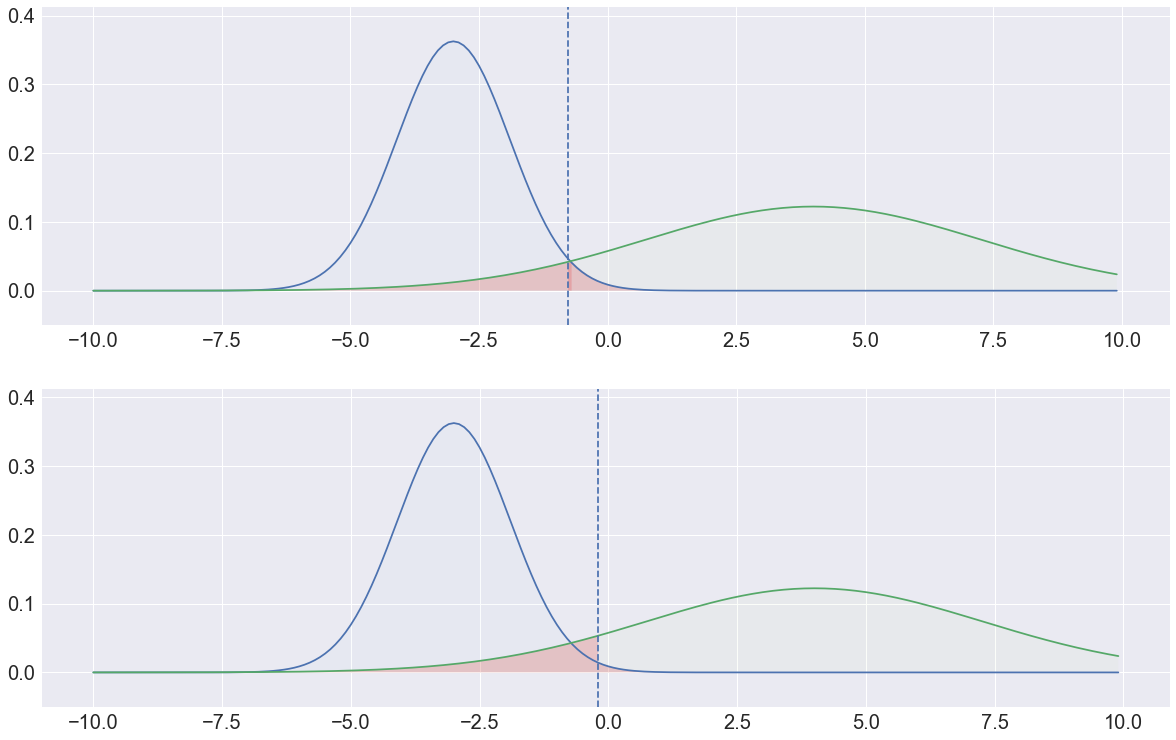

In [11]:
plot_bayesian_rule_minimizes()

## Naiwny klasyfikator Bayesowski

1. __liczba przykładów__ dla dobrej estymacji gęstości potrzeba ich dużo
  * __wymiarowość__ problemu utrudnia
  > Klasyfikacji domu: _luksusowe mieszkanie_/_barak_/_wysokościowiec_/etc zależny od dwóch parametrów  $x_1$: powierzchni oraz $x_2$: roku budowy
  > 
  > Wtedy
  $$\begin{align}
  p(y=c_k\mid x_1,x_2)&=\frac{p(x_1,x _2\mid c_k)\,p(c_k)}{p(x_1,x_2)}\\\\
  &\hskip3em\text{$p(x_1, x_2)$ ustalony}\\\\
  &\propto p(x_1,x_2\mid y_k)\,p(c_k)\\\\
  &\hskip3em\text{$x_1$ i $x_2$ niezależne pod warunkiem $c_k$}\\\\
  &={}p(x_1\mid c_k)\,p(x_2\mid c_k)\,p(c_k)\\\\
  &\hskip3em\text{z reguły Bayesa}\\\\
  &=\frac{p(c_k\mid x_1)\,p(x_1)}{p(c_k)}\frac{p(c_k\mid x_2)\,p(x_2)}{p(c_k)}\,p(c_k)\\\\
  &=\frac{p(c_k\mid x_1)\,p(c_k\mid x_2)p(x_1)\,p(x_2)}{p(c_k)}\\\\
  &=\frac{p(c_k\mid x_1)\,p(c_k\mid x_2)}{p(c_k)}
  \end{align}$$
  
2. __naiwny klasyfikator bayesowski__ (naiwne) założenie, że atrybuty problemu są __statystycznie niezależne pod warunkiem klasy__
  * wtedy $$p(x\mid c_k)=\prod_{i=1}^D p(x_i\mid c_k)\;\;\;k=1,\dots,K$$
  * __gausowskie rozkłady__ $p(x_i\mid c_k)$ 
    * potrzeba średnich i wariancji dla wymiarów 
    * razem $2\,D$ parametrów
  * z reguły Bayesa
$$\begin{align}
p(c_k\mid x_1,\dots,x_D)
&=\frac{\prod_{i=1}^D p(x_i\mid c_k)\,p(c_k)}{\sum_j\prod_{i=1}^D p(x_i\mid  c_j)\,p(c_j)}\\\\
&=\frac{\prod_{i=1}^Dp_k(x_i)\pi_k}{\sum_j\prod_{i=1}^Dp_j(x_i)\pi_j}
\end{align}
$$

3. __przekleństwo wymiarowości__  
  * wraz ze wzrostem wymiaru trzeba więcej danych
  * generalnie $N^D$ danych jest potrzebnych w $D$ wymiarach
4. __$x_i$ dyskretne__ 
  * obliczenie $p_k(x_i)$ jest ułamkiem liczby przykladów z klasy $y=c_k$ z wartością $x_i$ 
  * __mała liczność__ $p_k(x_i)=0$
    * wtedy posterior będzie $p(c_k\mid \{x_i\})=0\,/\,0$
  * __wygładzanie Laplace'a__: dodać małe $\epsilon$ do wszystkich $p_k(x_i)$
    * wygląda jak trik
    * jest równoważne wprowadzeniu pewnego prioru

### Gausowski klasyfikator Bayesa
1. __opuścić założenie__ o warunkowej niezależności współrzędnych
  * daje __gausowski klasyfikator Bayesa__
  * $p(x\mid c_k)=p_k(x)$ bardziej złożone
  $$p_k(x)=\frac{1}{|\Sigma_k|^{1/2}(2\pi)^{D/2}} \exp\left(-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)\right),$$
  gdzie $\Sigma_k$ jest macierzą kowariancji
  * macierz $\Sigma_k$ estymowana z przykładów
    * problem z estymacją gdy mało przykładów w klasie
    * może być współdzielona
    * wprowadza pewne założenia _a priori_
2. znacznie bardziej złożony obliczeniowo

In [12]:
def simple_bayesian(data='circles', classifier='Gaussian', centers=2,
                          n_samples=1000, noise = 0.1):
    if data == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise)
        reds, blues = (y == 0, y == 1)
    elif data == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
        reds, blues = (y == 0, y == 1)       
    elif data == 'classification':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_repeated=0,
                                  n_clusters_per_class=1)
        reds, blues = (y == 0, y == 1)
    elif data == 'blobs':
        X, y = make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=noise)
        reds, blues = (y == 0, y == 1)
    else:
        print('simple_classification: undefined data set: {}'.format(data))
     
    h = 0.01
    margin = 0.1
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig, ax = plt.subplots(figsize=(12, 12))
    cm = plt.cm.gist_rainbow
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    ax.plot(X[reds, 0], X[reds, 1], 'r*', lw=8, marker='o')
    ax.plot(X[blues, 0], X[blues, 1], 'b*', marker='o')
    
    if classifier == "Gaussian":
        clf = GaussianNB()
    elif classifier == "Bernoulli":
        clf = BernoulliNB()
    elif classifier == "LDA":
        clf = LDA()
    elif classifier == "QDA":
        clf = QDA()
    else:
        raise ValueError("Classifier {} not defined".format(classifier))
    clf.fit(X, y)
    score = clf.score(X, y)

    if hasattr(clf, 'decision_function'):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha = 0.25)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

data = "circles" | "moons" | "classification" | "blobs"
classifier = "Gaussian" | "Bernoulli" | "LDA" | "QDA"
n_samples = 1000
noise = 0.1

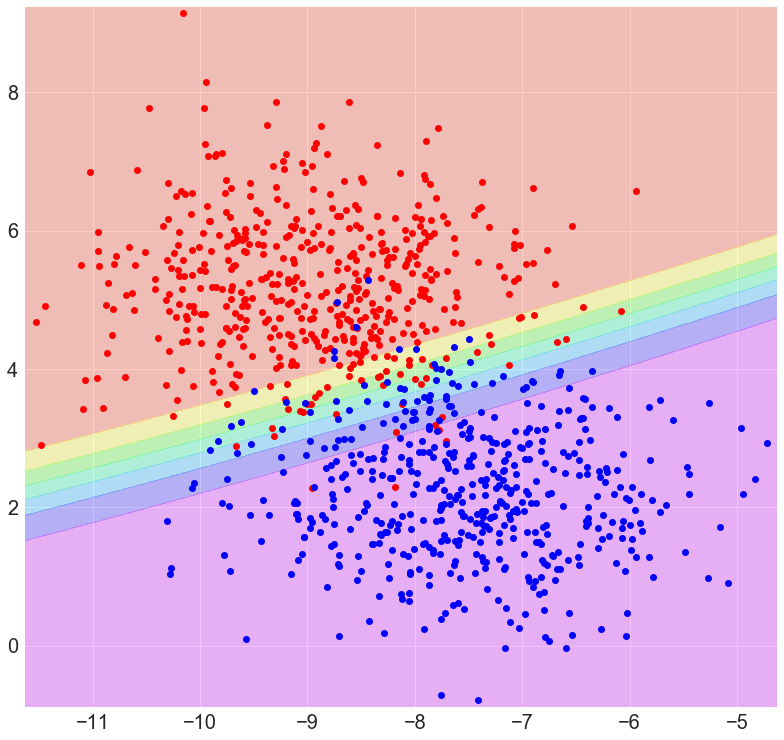

In [17]:
simple_bayesian(data='blobs', classifier="Gaussian", noise=1)

## Fisher's linear discriminant
1. __rzutowanie__ danych
  * dla lepszego rozdziału
  * możliwe na oś $\mu_1 - \mu_2$
2. wybór rzutowania aby
  * __maksymalizować odległość__  przykładów z różnych klas
  * __minimalizować wariancje__ przykładów w klasach
3. __maksymalizacja__ współczynnika dyskryminacyjnego Fishera $$FDR=\frac{(\widetilde\mu_1-\widetilde\mu_2)^2}{\sigma_1^2+\sigma_2^2}$$
gdzie $\widetilde\mu_1, \widetilde\mu_2$ to średnie __po rzutowaniu__
4. __rozszerzenie__ na więcej klas możliwe
5. celem jest __maksymalizacja__ marginesów między klasami

In [20]:
def plot_two_blobs():
    def rotate_vector(v, angle, anchor):
        """Rotate a vector `v` by the given angle, relative to the anchor point."""
        x, y = v

        x = x - anchor[0]
        y = y - anchor[1]

        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)

        nx = x*cos_theta - y*sin_theta
        ny = x*sin_theta + y*cos_theta

        nx = nx + anchor[0]
        ny = ny + anchor[1]
        return [nx, ny]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    X, y = make_blobs(centers=2, n_samples=250)
    #y = [min(x, 1) for x in z]
    ax[0].scatter(X[:, 0], X[:, 1], c=y+2)
    ind_0 = y == 0
    ind_1 = y == 1
    mu_0 = np.mean(X[ind_0, :], 0)
    ax[0].plot(mu_0[0], mu_0[1], 'b*', markersize=10)
    mu_1 = np.mean(X[ind_1, :], 0)
    ax[0].plot(mu_1[0], mu_1[1], 'r*', ms=10)

    x_range = np.arange(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 0.05)
    slope = (mu_1[1] - mu_0[1]) / (mu_1[0] - mu_0[0])
    intercept = mu_1[1] - slope * mu_1[0]
    ax[0].plot(x_range, x_range * slope + intercept, 'k')
    d_0 = X[ind_0, 0]
    d_1 = X[ind_1, 0]
    dens_0 = gaussian_kde(d_0)
    dens_1 = gaussian_kde(d_1)
    dens_0.covariance_factor = lambda : 0.25
    dens_0._compute_covariance()
    dens_1.covariance_factor = lambda : 0.25
    dens_1._compute_covariance()
    xs = np.linspace(min(X[:, 0]), max(X[:, 0]), 200)
    
    ax_t = ax[0].twinx()
    ax_t.plot(xs, dens_0(xs), c='b')
    ax_t.plot(xs, dens_1(xs), c='r')

    # rotate data and compute density plot
    center_x = (mu_0[0] + mu_1[0]) / 2
    center_y = (mu_0[1] + mu_1[1]) / 2
    
    # line tangent to line joining centers -- simplest decision boundary
    # intercept_tangent = center_y + slope * center_x
    # intercept_tangent = center_y + center_x / slope
    intercept_tangent = center_x / slope + center_y
    ax[0].plot(x_range, -(1. / slope) * x_range + intercept_tangent, 'k--')
    center = (center_x, center_y)
    ax[0].plot(center_x, center_y, 'o', ms=12, alpha=0.85)
    #ax[1].plot(center_x, center_y, 'k+', ms=12)
    XR = np.zeros(X.shape)
    angle = -np.arctan(slope)
    for i in range(X.shape[0]):
        XR[i, :] = rotate_vector(X[i, :], angle, center)
    yr = y + 2
    new_center = rotate_vector(center, angle, center)
    ax[1].plot(new_center[0], new_center[1], 'k+', ms=12)
    ax[1].scatter(XR[:, 0], XR[:, 1], c=yr, marker='x')

    d_0 = XR[ind_0, 0]
    d_1 = XR[ind_1, 0]
    dens_0 = gaussian_kde(d_0)
    dens_1 = gaussian_kde(d_1)
    dens_0.covariance_factor = lambda : 0.25
    dens_0._compute_covariance()
    dens_1.covariance_factor = lambda : 0.25
    dens_1._compute_covariance()
    min_val = min(min(X[:, 0]), min(XR[:, 0]), min(X[:, 1]), min(XR[:, 1])) - 0.5
    max_val = max(max(X[:, 0]), max(XR[:, 0]), max(X[:, 1]), max(XR[:, 1])) + 0.5
    xs = np.linspace(min_val, max_val, 200)
    
    ax_twin = ax[1].twinx()
    ax_twin.plot(xs, dens_0(xs), c='b')
    ax_twin.plot(xs, dens_1(xs), c='r')


    ax[0].set_xlim(min_val, max_val)
    ax[0].set_ylim(min_val, max_val)
    ax[1].set_xlim(min_val, max_val)
    ax[1].set_ylim(min_val, max_val)
    
    fig.suptitle("Uproszczona wizualizacja metody Fischera")
    plt.tight_layout()

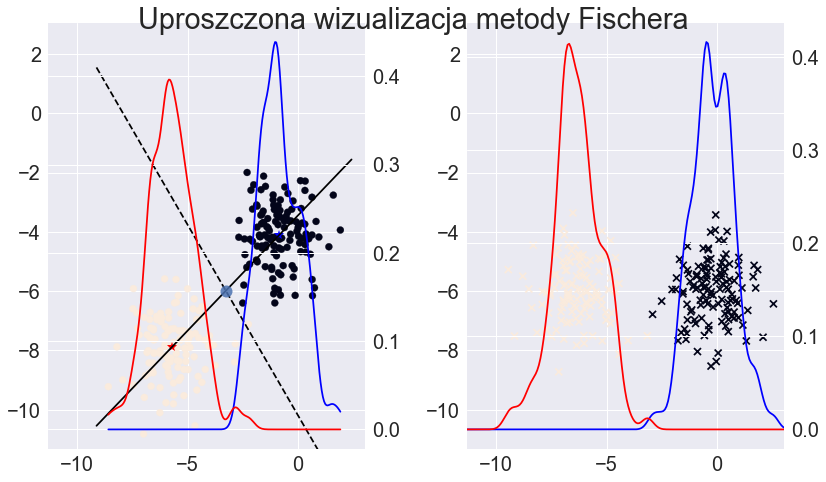

In [21]:
plot_two_blobs()

## Linear Discriminant Analysis
1. __założenie__ wszystkie klasy mają identyczne macierze kowariancji
2. __gausowskie__ danych w klasach
  * granice w LDA są __liniowe__ $p(y=c_k)=p(y=c_j)\hskip1em\forall k\neq j$
  * wypadają tam, gdzie prawdopodobieństwa klas są równe
3. QDA zakłada także gausowskie rozkłady
  * algorytm estymuje macierze kowariancji 
    * estymacja macierzy kowariancji z danych jest ograniczona
  * __kwadratowe__ granice między klasami 

In [22]:
def lda_qda(mode='linear', n_samples=100, centers=2, priors=[1, 1], 
                   odds='odds'):
    if len(priors) != centers:
        centers = max(centers, len(priors))
        #return 'Number of centers and length of priors differ!'
    priors = np.array(priors) / np.sum(priors)
    X, y = make_blobs(n_samples=n_samples, centers=centers)

    if mode == 'linear':
        cls = LDA(priors=priors)
    elif mode == 'quadratic':
        cls = QDA(priors=priors)
    cls.fit(X, y)
    
    fig_lines = (centers + 2) // 2
    fig, ax = plt.subplots(fig_lines, 2, figsize=(12, fig_lines * 6))
    cmap = plt.cm.gist_rainbow
    
    h=0.025
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape)
    
    colors = sns.color_palette("Accent", centers)
    ax[0, 0].pcolormesh(xx, yy, Z, cmap=cmap)
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=[colors[yy] for yy in y], 
                     edgecolors='k', cmap=cmap, s=40)
    ax[0, 0].set_xlim(xx.min(), xx.max())
    ax[0, 0].set_ylim(yy.min(), yy.max())
    ax[0, 0].set_xticks(())
    ax[0, 0].set_yticks(())
    
    
    # odds lub log-odds dla poszczegolnych klas
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    for n in range(centers):
        if odds == 'odds':
            Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        elif odds == 'log':
            Z = cls.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        Z = Z.reshape(xx.shape)
        row = (n + 1) // 2; col = (n + 1) % 2
        #cax = ax[row, col].imshow(Z, interpolation='nearest', cmap=cmap)
        ax[row, col].pcolormesh(xx, yy, Z, cmap=cmap)
        ax[row, col].scatter(X[:, 0], X[:, 1], c=[colors[yy] for yy in y], 
                             edgecolors='k', cmap=cmap, s=40)
        ax[row, col].set_xlim(xx.min(), xx.max())
        ax[row, col].set_ylim(yy.min(), yy.max())
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
    plt.tight_layout()

/Users/igorpodolak/anaconda/envs/tf/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


xx: (395, 583)
yy: (395, 583)


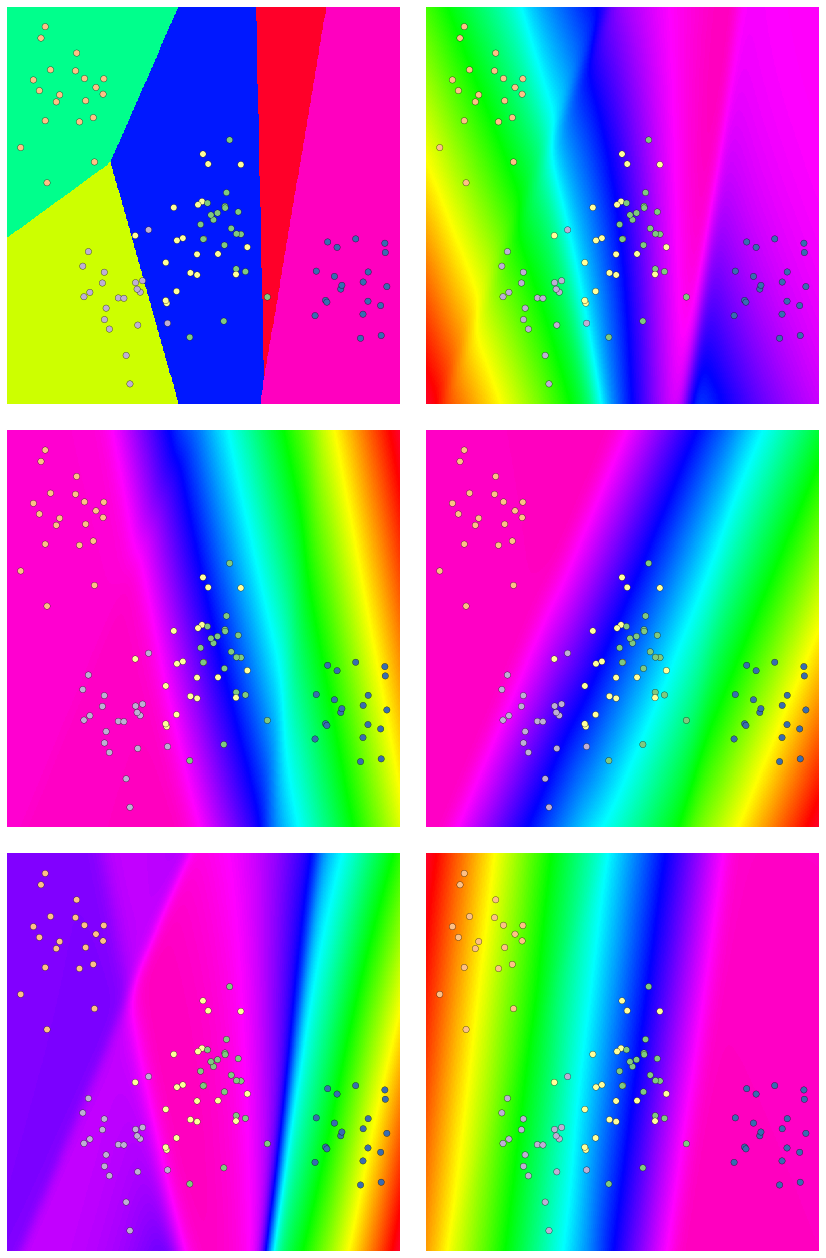

In [23]:
lda_qda(priors=[1, 2, 0.1, 15, 3], odds='log', mode='linear')